In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
%matplotlib inline

import zipfile
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
zf = zipfile.ZipFile('C:/Users/Serueja/Downloads/tabular-playground-series-sep-2022.zip')
test = pd.read_csv(zf.open('test.csv'))
train = pd.read_csv(zf.open('train.csv'))
submission_example = pd.read_csv(zf.open('sample_submission.csv'))

**INITIAL DATA EXPLORATION**

In [ ]:
train.head(20)

In [ ]:
train['product'].nunique()

In [ ]:
(train.isna().any(), test.isna().any())

In [ ]:
train.groupby('date')['row_id'].count()

In [ ]:
(train.date.nunique(), test.date.nunique())

In [ ]:
train[train['date'] == '2017-01-01'].head()
train['date'] = pd.to_datetime(train['date'], yearfirst=True)
train['new_date'] = train['date'].dt.to_period('M')

In [ ]:
train.groupby(['country', 'store'])['num_sold'].sum()

**DATA VISUALIZATION**

Here we can see that probably we need to log(x+1) our sales in order to put it through regression models



Also we can notice similarities in our store sales distribution, probably we would need same function to transform the data into normal distribution 

In [ ]:
train[train['store'] == 'KaggleMart']['num_sold'].hist(bins=100)

In [ ]:
train[train['store'] == 'KaggleRama']['num_sold'].hist(bins=100)

In [ ]:
country_sales = train.groupby('country')['num_sold'].sum()

country_sales.sort_values(inplace=True)
sns.barplot(x=country_sales.index, y=country_sales.values)
store_sales = train.groupby('store')['num_sold'].sum()

sns.barplot(x=store_sales.index, y=store_sales.values)

In [ ]:
train.info()

In [ ]:
books_over_time_df = []
k=train[train['product'] == 'Kaggle Advanced Techniques'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)
k=train[train['product'] == 'Kaggle Getting Started'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k) 
k=train[train['product'] == 'Kaggle Recipe Book'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)
k=train[train['product'] == 'Kaggle for Kids: One Smart Goose'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)
k=train[train['product'] == 'Kaggle Advanced Techniques'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)

In [ ]:
#fig, ax = plt.subplots(3, 2, figsize=(5 ,5))
for i in range(len(books_over_time_df)):
    plt.plot_date('new_date', 'num_sold', data = books_over_time_df[i],linestyle='solid')
    plt.xticks(rotation=45)
    plt.xlabel('Месяцы')
    plt.ylabel('Продажи')
    plt.show()

**Here we can see an obvious seasonality and trend, so we must define a trend for each book or even for each country and each book as a pair, in order to make our predictions more accurate** 

In [ ]:
books_over_time_df[0]['new_date'] = books_over_time_df[0]['new_date'].astype('datetime64')
ax = sns.lineplot(data=books_over_time_df[0], x = 'new_date', y = 'num_sold')
sns.scatterplot(data=books_over_time_df[0], x = 'new_date', y = 'num_sold', ax=ax)
ax.set(xlabel='Месяц', ylabel='Продано копий')
sns.set(rc={"figure.figsize":(5, 5)}, font_scale=2)
plt.xticks(rotation=45)
plt.show()

In [ ]:
country_store_sales = train.groupby(['store', 'country'])['num_sold'].sum()
country_store_sales.sort_values(inplace=True)

country_store_sales
ax = country_store_sales.unstack(level=0).plot(kind='bar', subplots=False, rot=0, figsize=(6, 8), layout=(4, 6))
plt.tight_layout()

**Lets devide our dataset into 48 different sections, for each country, store, and product**

**FEATURE ENGINEERING**

In [ ]:
print(train.head())
X_train = []
X_test = []

#country = Belgium, store = KaggleMart
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Belgium, store = KaggleRama
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = France, store = KaggleMart
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = France, store = KaggleRama
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Germany, store = KaggleMart
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Germany, store = KaggleRama
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Italy, store = KaggleMart
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Italy, store = KaggleRama
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Poland, store = KaggleMart
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Poland, store = KaggleRama
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Spain, store = KaggleMart
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Poland, store = KaggleRama
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

In [ ]:
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Belgium, store = KaggleRama
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = France, store = KaggleMart
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = France, store = KaggleRama
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Germany, store = KaggleMart
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Germany, store = KaggleRama
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Italy, store = KaggleMart
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Italy, store = KaggleRama
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Poland, store = KaggleMart
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Poland, store = KaggleRama
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Spain, store = KaggleMart
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Poland, store = KaggleRama
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

In [ ]:
X_train[46].head()

In [ ]:
for i in X_train:
    i.drop(['row_id', 'country', 'store', 'product'], axis=1, inplace=True)
for i in X_test:
    i.drop(['row_id', 'country', 'store', 'product'], axis=1, inplace=True)

In [ ]:
from matplotlib.pyplot import figure, subplot
plt.rcParams["figure.figsize"] = (20,20)
fig, ax = plt.subplots(4)
for i in range(4):
    ax[i].plot('date', 'num_sold', data=X_train[i], linestyle='solid')
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Num Sold')

We now also can and should think of model validation, especially data, which we will use for it. My idea is to chop off a whole year of a train dataset and check SMAPE on that chunk of data, then we could manipulate the hyperparameters and then let our models learn from another year, and only then predict values for test dataset.

In [ ]:
X_train_mini = []
X_eval = []

In [ ]:
for i in X_train:
    X_train_mini.append(i[i['date'] <= '2020-01-01'])
    X_eval.append(i[i['date'] > '2020-01-01'])

In [ ]:
X_train_mini[0]

**Here let's try using from statsmodels.tsa.seasonal.STL**

In [ ]:
temp = X_train[0].copy()

In [ ]:
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

stl = STL(temp, seasonal=51, robust=True)
res = stl.fit()
fig = res.plot()

In [ ]:
# X_train[0]
plt.rcParams["figure.figsize"] = (15, 10)
plt.plot_date(x=X_train[0]['date'], y=X_train[0]['num_sold'])

Plotting the trend

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
detrended = signal.detrend(X_train[0].num_sold.values)
#plt.plot(X_train[0]['num_sold'] - detrended)
#plt.plot(X_train[0]['num_sold'])

In [ ]:
temp

In [ ]:
temp = X_train[0].copy()

temp.reset_index(inplace=True)
temp.drop('index', axis=1, inplace=True)
temp.date = temp.date.astype('datetime64[ns]')
temp

In [ ]:
models = [] #gotta be 48 models

**Now we did all the preparations we need, let's dive into modelling**

Here we start with a common practice CalendarFourier and DP. I guess here we could pipelines, but to make things faster I will stick with an ancient and not so pretty way. Hope some day will figure out how to use pipelines here.

In [ ]:
X_train[0].tail()

In [ ]:
date_range_1 = pd.date_range(start='2017-01-01', end='2020-12-31')
date_range_2 = pd.date_range(start='2017-01-01', end='2019-12-31')
date_range_3 = pd.date_range(start='2021-01-01', end='2021-12-31')
date_range_test_for_2 = pd.date_range(start='2020-01-01', end='2020-12-31')

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
#
# fourier = CalendarFourier(freq='A', order=550)

# dp = DeterministicProcess(
#     index=temp.date,
#     constant=True,               # dummy feature for bias (y-intercept)
#     order=2,                     # trend (order 1 means linear)
#     seasonal=True,               # weekly seasonality (indicators)
#     additional_terms=[fourier],  # annual seasonality (fourier)
#     drop=True,                   # drop terms to avoid collinearity
# )
fourier = CalendarFourier(freq='A', order=550)

dp = DeterministicProcess(
    index=temp.date,
    constant=True,               # dummy feature for bias (y-intercept)
    order=2,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

In [ ]:
fourier_d_r_1 = CalendarFourier(freq='A', order=200)
dp_d_r_1 = DeterministicProcess(
    index=date_range_1,
    constant=True,               # dummy feature for bias (y-intercept)
    order=2,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier_d_r_1],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

In [ ]:
fourier_d_r_2 = CalendarFourier(freq='A', order=200)
dp_d_r_2 = DeterministicProcess(
    index=date_range_2,
    constant=True,               # dummy feature for bias (y-intercept)
    order=2,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier_d_r_2],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

**Рубрика эксперименты**

In [101]:
#тут у нас будет дэйт рэндж и календарь Фурье

experiment_date_range = pd.date_range(start='2017-01-01', end='2019-12-31')

experiment_fourier = CalendarFourier(freq='A', order=500)

experiment_dp = DeterministicProcess(
    index=experiment_date_range,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[experiment_fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

experiment_date_range

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=1095, freq='D')

In [102]:
#тут будет сэмпл и аут оф сэмпл + дата для обучения + дата для проверки

experiment_in_sample = experiment_dp.in_sample()

experiment_out_of_sample = experiment_dp.out_of_sample(steps=365)

#data for learning

experiment_train_y = X_train[0][:1095]['num_sold']
experiment_test_y = X_train[0][1096:]['num_sold']

experiment_train_y = experiment_train_y.reset_index()
experiment_train_y.drop('index', axis = 1, inplace=True)
experiment_test_y = experiment_test_y.reset_index()
experiment_test_y.drop('index', axis = 1, inplace=True)

len(experiment_train_y), len(experiment_in_sample), len(experiment_out_of_sample), len(experiment_test_y)

(1095, 1095, 365, 365)

In [103]:
#эта ячейка будет для обучения и валидации модельки

experiment_linear_model = LinearRegression(fit_intercept=False)

experiment_linear_model.fit(experiment_in_sample,experiment_train_y)

smape(experiment_linear_model.predict(experiment_out_of_sample), experiment_test_y)

#smape очень высокая, что говорит о переобученности модели

num_sold    14.994571
dtype: float64

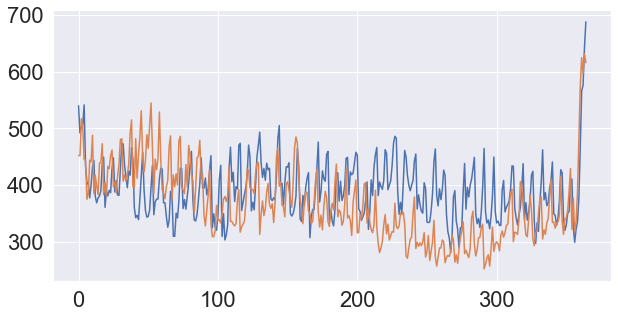

In [104]:
plt.plot(experiment_linear_model.predict(experiment_out_of_sample))
plt.plot(experiment_test_y)

In [105]:
smape(experiment_linear_model.predict(experiment_in_sample), experiment_train_y)

num_sold    3.948867
dtype: float64

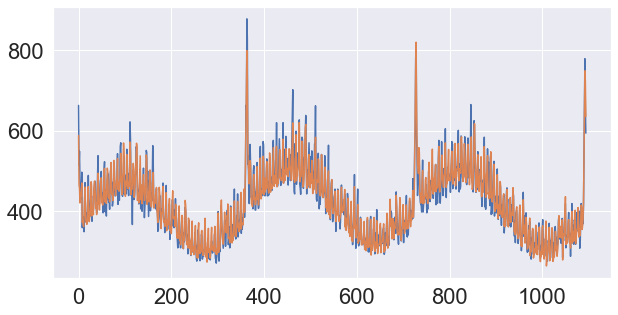

In [106]:
plt.plot(experiment_train_y)
plt.plot(experiment_linear_model.predict(experiment_in_sample))

**Конец эксперимента**

In [ ]:
X = dp.in_sample()

In [ ]:
date_range_1_dp_sample = dp_d_r_1.in_sample()

In [ ]:
date_range_2_dp_sample = dp_d_r_2.in_sample()

In [ ]:
date_range_2_df_OUT = dp_d_r_2.out_of_sample(steps=365)

In [ ]:
temp_model = LinearRegression(fit_intercept=False)
y1 = X_train[0]['num_sold'][:1095]
y2 = X_train[0]['num_sold'][1096:]

temp_model.fit(date_range_2_dp_sample, y1)

In [ ]:
len(temp_model.predict(date_range_2_df_OUT)), len(y2)

In [ ]:
smape(temp_model.predict(date_range_2_df_OUT), y2)

In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)

plt.plot(temp_model.predict(date_range_2_df_OUT))
plt.plot(y2.reset_index().drop('index', axis=1))


In [ ]:
temp_model = LinearRegression(fit_intercept=False)
y1 = X_train[0]['num_sold'][:1096]
y2 = X_train[0]['num_sold'][1096:]
X1 = X[:1096]
X2 = X[1096:]

In [ ]:
X1_fore = dp.out_of_sample(steps=365)

Next cell is very very important

In [ ]:
temp_model = LinearRegression(fit_intercept=False)
y1 = X_train[0]['num_sold'][:1096]
y2 = X_train[0]['num_sold'][1096:]
X1 = X[:1096]

X2 = pd.out
_1 = temp_model.fit(X1, y1)

smape(temp_model.predict(X2), y2)

In [ ]:
y = X_train[0]['num_sold']
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

ax = plt.plot(model.predict(X))
ax = plt.plot(X_train[0]['num_sold'].values)

smape(model.predict(X), X_train[0]['num_sold'])

In [ ]:
model.predict(X)